In [1]:
import pandas as pd
import gensim.models
import numpy as np
import my_plots as mp
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.set_option('display.max_rows', 10)

---
### Read in Data

The dataset from Kaggle contained four different csvs: two presidential debates, one vice presidential debate, and two town halls.

In [3]:
# read in the data
debate_01 = pd.read_csv('data/us_election_2020_1st_presidential_debate.csv').drop_duplicates() #dropping duplicates right away when I read the file
pd.set_option('display.max_columns', None)
debate_01.head(3)

,speaker,minute,text
0,Chris Wallace,01:20,Good evening from the Health Education Campus ...
1,Chris Wallace,02:10,This debate is being conducted under health an...
2,Vice President Joe Biden,02:49,"How you doing, man?"


In [4]:
debate_02 = pd.read_csv('data/us_election_2020_2nd_presidential_debate.csv').drop_duplicates() #dropping duplicates right away when I read the file
pd.set_option('display.max_columns', None)
debate_02.head(3)

,speaker,minute,text
0,Kristen Welker,00:18,"Good evening, everyone. Good evening. Thank yo..."
1,Donald Trump,07:37,How are you doing? How are you?
2,Kristen Welker,07:58,And I do want to say a very good evening to bo...


In [5]:
biden_th = pd.read_csv('data/us_election_2020_biden_town_hall.csv').drop_duplicates() #dropping duplicates right away when I read the file
pd.set_option('display.max_columns', None)
biden_th.head(3)

,speaker,minute,text
0,George Stephanopoulos,00:41,"Hey, and welcome to our town hall with Joe Bid..."
1,Joe Biden,00:46,Good to be with you.
2,George Stephanopoulos,00:47,We’re here with a group of Pennsylvania voters...


In [6]:
trump_th = pd.read_csv('data/us_election_2020_trump_town_hall.csv').drop_duplicates() #dropping duplicates right away when I read the file
pd.set_option('display.max_columns', None)
trump_th.head(3)

,speaker,minute,text
0,Savannah Guthrie,03:50,"It’s nothing but noise. What? Okay. All right,..."
1,Speaker 1,04:35,This is an NBC news special presentation of To...
2,Savannah Guthrie,04:40,"Tonight, Donald Trump in the arena. His first ..."


In [7]:
debate_vp = pd.read_csv('data/us_election_2020_vice_presidential_debate.csv').drop_duplicates() #dropping duplicates right away when I read the file
pd.set_option('display.max_columns', None)
debate_vp.head(3)

,speaker,minute,text
0,Susan Page,00:00,Good evening. From the University of Utah in S...
1,Susan Page,01:21,"These are tumultuous times, but we can and wil..."
2,Kamala Harris,02:13,"Thank you, Susan. Well, the American people ha..."


---
### Calculate total time for each statement

While the 'minute' column was helpful to know when the speaker started talking, I thought having the length (in seconds) of the text would be more helpful. Hence, the first thing I did was calculate that.

This meant converting the 'minute' column to just seconds and marking that as the 'start time' of the sentnece, making a new column 'end time' that was when the next speaker started talking, and then subtracting those two to find the total time of the text. Unfortunatley, the clock restarted during multiple debates, so I had to factor this in to my calculations.

In [8]:
def calc_total_times(df):
    
    # when the clock resets there is an none value, so this is replacing that with a 0
    df['minute'] = df['minute'].fillna('00:00') 
    
    # convert the 'minute' column to a int of seconds, this is the 'start time'
    df['start_time'] = df['minute'].apply(lambda x: \
        ((int(x[:2])*60) + (int(x[3:]))) if (len(x)==5) \
        else ((int(x[:2])*3600) + (int(x[3:5])*60) + (int(x[6:]))) ) 

    # the end time is just the start time offset by one
    df['end_time'] = df['start_time'].shift(-1) 
    
    # the last column will have no end time and the none value will mess up calculations, so drop this
    df.drop(df.tail(1).index,inplace=True) 
    
    df['end_time'] = df['end_time'].apply(lambda x: int(x))
    
    # subtract the start and end times to get 'total_time'
    df['total_time'] = df[['start_time', 'end_time']].apply(lambda x: \
    x['end_time'] - x['start_time'], axis = 1)
    df.drop(['start_time', 'end_time', 'minute'], axis = 1, inplace = True)
    
    return df

In [9]:
debates = [debate_01, debate_02, debate_vp, biden_th, trump_th]
for debate in debates:
    debate = calc_total_times(debate)

In [10]:
debate_01

,speaker,text,total_time
0,Chris Wallace,Good evening from the Health Education Campus ...,50
1,Chris Wallace,This debate is being conducted under health an...,39
2,Vice President Joe Biden,"How you doing, man?",2
3,President Donald J. Trump,How are you doing?,0
4,Vice President Joe Biden,I’m well.,20
...,...,...,...
783,President Donald J. Trump,I want to see an honest ballot cut-,2
784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4
785,President Donald J. Trump,I want to see an honest ballot count.,1
786,Chris Wallace,We’re going to leave it there-,1


Because the clock restarted, there were a few pieces of text that had inaccurate times. For these, I went back to the actual debate and just timed the sections. These are manually inserted below.

In [11]:
debate_01.at[178, 'total_time'] = 3
debate_02.at[88, 'total_time'] = 13
debate_02.at[336, 'total_time'] = 43

I then put back in the 'start_time' column using a cumulative sum of the accurate total times.

In [12]:
for debate in debates:
    debate['start_time'] = debate['total_time'].cumsum().shift(1)
    debate.at[0, 'start_time'] = 0
    debate['start_time'] = debate['start_time'].apply(lambda x: int(x))

Another thing I wanted to do is standardize names. The different csvs called the candidates different things which would make analysis difficult in the future. Hence I changed them to all be consistent here.

In [13]:
debate_01['speaker'] = debate_01['speaker'].replace(['Vice President Joe Biden'], 'Joe Biden')
debate_01['speaker'] = debate_01['speaker'].replace(['President Donald J. Trump'], 'Donald Trump')
trump_th['speaker'] = trump_th['speaker'].replace(['President Trump'], 'Donald Trump')

debate_01

,speaker,text,total_time,start_time
0,Chris Wallace,Good evening from the Health Education Campus ...,50,0
1,Chris Wallace,This debate is being conducted under health an...,39,50
2,Joe Biden,"How you doing, man?",2,89
3,Donald Trump,How are you doing?,0,91
4,Joe Biden,I’m well.,20,91
...,...,...,...,...
783,Donald Trump,I want to see an honest ballot cut-,2,5629
784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4,5631
785,Donald Trump,I want to see an honest ballot count.,1,5635
786,Chris Wallace,We’re going to leave it there-,1,5636


In [14]:
debate_02

,speaker,text,total_time,start_time
0,Kristen Welker,"Good evening, everyone. Good evening. Thank yo...",439,0
1,Donald Trump,How are you doing? How are you?,21,439
2,Kristen Welker,And I do want to say a very good evening to bo...,29,460
3,Kristen Welker,The goal is for you to hear each other and for...,36,489
4,Kristen Welker,… during this next stage of the coronavirus cr...,1,525
...,...,...,...,...
506,Donald Trump,Success is going to bring us together. We are ...,21,5862
507,Kristen Welker,"All right. Vice President Biden, same question...",8,5883
508,Joe Biden,"I will say, I’m an American President. I repre...",22,5891
509,Joe Biden,"We can grow this economy, we can deal with the...",34,5913


In [15]:
debate_vp

,speaker,text,total_time,start_time
0,Susan Page,Good evening. From the University of Utah in S...,81,0
1,Susan Page,"These are tumultuous times, but we can and wil...",52,81
2,Kamala Harris,"Thank you, Susan. Well, the American people ha...",68,133
3,Kamala Harris,"Can you imagine if you knew on January 28th, a...",56,201
4,Susan Page,"Thank you, Senator Harris-",1,257
...,...,...,...,...
321,Kamala Harris,"First of all, I love hearing from our young le...",19,2998
322,Kamala Harris,"And brings me to Joe, Joe Biden. One of the re...",27,3017
323,Kamala Harris,Joe has a longstanding reputation of working a...,26,3044
324,Kamala Harris,"Brecklin, when you think about the future, I d...",27,3070


In [16]:
biden_th

,speaker,text,total_time,start_time
0,George Stephanopoulos,"Hey, and welcome to our town hall with Joe Bid...",5,0
1,Joe Biden,Good to be with you.,1,5
2,George Stephanopoulos,We’re here with a group of Pennsylvania voters...,15,6
3,Joe Biden,Okay.,0,21
4,George Stephanopoulos,"And we’re going to start with Nicholas Fed, an...",6,21
...,...,...,...,...
216,Joe Biden,"Well, it could say I’m a lousy candidate, and ...",72,5075
217,George Stephanopoulos,One more break. We’ll be right back. And we ar...,261,5147
218,Joe Biden,"Yeah. And by the way, before I came up here, I...",71,5408
219,George Stephanopoulos,But you expect to be there?,1,5479


In [17]:
trump_th

,speaker,text,total_time,start_time
0,Savannah Guthrie,"It’s nothing but noise. What? Okay. All right,...",45,0
1,Speaker 1,This is an NBC news special presentation of To...,5,45
2,Savannah Guthrie,"Tonight, Donald Trump in the arena. His first ...",8,50
3,Donald Trump,"I’m feeling great, I don’t know about you. How...",3,58
4,Savannah Guthrie,"With tonight’s debate canceled, the President ...",9,61
...,...,...,...,...
399,Donald Trump,That’s right.,1,3566
400,Savannah Guthrie,There are people who want to know why they sho...,8,3567
401,Donald Trump,Because I’ve done a great job. We have the str...,35,3575
402,Savannah Guthrie,I got to leave it there. I got a wrap from the...,5,3610


---
### Text Preprocessing

I then moved on to tokenization and lemmanization.

In [18]:
import gensim
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [19]:
# these stopwords started coming up when I did tf-idf and seemed like noise, so I went back and took them out here
custom_stops = ['debate', 'topic', 'candidate', 'presidential', 'nominee', 'question', 'segment', 'minute', 'audience',
                'welcome', 'hey', 'town', 'hall', 'tonight']
def lemmatize_text(tokens):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_words
def custom_stop_remove(tokens):
    no_stops = [word for word in tokens if word not in custom_stops]
    return no_stops

In [20]:
def pre_process(df):
    df['tokens'] = df['text'].apply(lambda x: gensim.parsing.preprocessing.remove_stopwords(x)) # remove stopwords
    df['tokens'] = df['tokens'].apply(lambda x: gensim.utils.simple_preprocess(x)) # tokenzie
    df['tokens'] = df['tokens'].apply(lemmatize_text) # lemmatize
    df['tokens'] = df['tokens'].apply(custom_stop_remove) # remove custom stopwords

In [21]:
for debate in debates:
    pre_process(debate)

In [22]:
debate_01

,speaker,text,total_time,start_time,tokens
0,Chris Wallace,Good evening from the Health Education Campus ...,50,0,"[good, evening, health, education, campus, cas..."
1,Chris Wallace,This debate is being conducted under health an...,39,50,"[this, conducted, health, safety, protocol, de..."
2,Joe Biden,"How you doing, man?",2,89,"[how, doing, man]"
3,Donald Trump,How are you doing?,0,91,"[how, doing]"
4,Joe Biden,I’m well.,20,91,[well]
...,...,...,...,...,...
783,Donald Trump,I want to see an honest ballot cut-,2,5629,"[want, honest, ballot, cut]"
784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4,5631,"[gentleman, that, end, crosstalk, this, end]"
785,Donald Trump,I want to see an honest ballot count.,1,5635,"[want, honest, ballot, count]"
786,Chris Wallace,We’re going to leave it there-,1,5636,"[we, re, going, leave, there]"


In [23]:
debate_02

,speaker,text,total_time,start_time,tokens
0,Kristen Welker,"Good evening, everyone. Good evening. Thank yo...",439,0,"[good, evening, everyone, good, evening, thank..."
1,Donald Trump,How are you doing? How are you?,21,439,"[how, doing, how, you]"
2,Kristen Welker,And I do want to say a very good evening to bo...,29,460,"[and, want, good, evening, you, this, cover, m..."
3,Kristen Welker,The goal is for you to hear each other and for...,36,489,"[the, goal, hear, american, people, hear, word..."
4,Kristen Welker,… during this next stage of the coronavirus cr...,1,525,"[stage, coronavirus, crisis, two, uninterrupted]"
...,...,...,...,...,...
506,Donald Trump,Success is going to bring us together. We are ...,21,5862,"[success, going, bring, together, we, road, su..."
507,Kristen Welker,"All right. Vice President Biden, same question...",8,5883,"[all, right, vice, president, biden, you, inau..."
508,Joe Biden,"I will say, I’m an American President. I repre...",22,5891,"[say, american, president, represent, you, vot..."
509,Joe Biden,"We can grow this economy, we can deal with the...",34,5913,"[we, grow, economy, deal, systemic, racism, at..."


### EDA

The first thing I wanted to do is compare the speaking times of the two candidates in their debates.

In [24]:
# I also quickly calculated the length of the tokens to have on hand
for debate in debates:
    debate['length'] = debate['tokens'].apply(lambda x: len(x))
debate_01

,speaker,text,total_time,start_time,tokens,length
0,Chris Wallace,Good evening from the Health Education Campus ...,50,0,"[good, evening, health, education, campus, cas...",44
1,Chris Wallace,This debate is being conducted under health an...,39,50,"[this, conducted, health, safety, protocol, de...",44
2,Joe Biden,"How you doing, man?",2,89,"[how, doing, man]",3
3,Donald Trump,How are you doing?,0,91,"[how, doing]",2
4,Joe Biden,I’m well.,20,91,[well],1
...,...,...,...,...,...,...
783,Donald Trump,I want to see an honest ballot cut-,2,5629,"[want, honest, ballot, cut]",4
784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4,5631,"[gentleman, that, end, crosstalk, this, end]",6
785,Donald Trump,I want to see an honest ballot count.,1,5635,"[want, honest, ballot, count]",4
786,Chris Wallace,We’re going to leave it there-,1,5636,"[we, re, going, leave, there]",5


In [25]:
# this function gets the total minutes for each candidate and the moderator
def get_speaker_times(df):
    biden = 0
    trump = 0
    moderator = 0
    for i, row in df.iterrows():
        if (row['speaker'] != 'Joe Biden') and (row['speaker'] != 'Donald Trump'):
            moderator += row['total_time']
        elif row['speaker'] == 'Joe Biden':
            biden += row['total_time']
        elif row['speaker'] == 'Donald Trump':
            trump += row['total_time']
    return round(moderator/60, 2), round(biden/60, 2), round(trump/60, 2)

moderator_min_01, biden_min_01, trump_min_01 = get_speaker_times(debate_01)
moderator_min_02, biden_min_02, trump_min_02 = get_speaker_times(debate_02)

print(f'moderator total mins first debate: {moderator_min_01}')
print(f'biden total seconds first debate: {biden_min_01}')
print(f'trump total seconds first debate: {trump_min_01}')
print('\n')
print(f'moderator total mins second debate: {moderator_min_02}')
print(f'biden total seconds second debate: {biden_min_02}')
print(f'trump total seconds second debate: {trump_min_02}')

moderator total mins first debate: 24.5
biden total seconds first debate: 35.32
trump total seconds first debate: 34.15


moderator total mins second debate: 22.25
biden total seconds second debate: 38.43
trump total seconds second debate: 38.82


These time was split between the two candidates much more evenly than I first would've expected. I then converted these times to percentages and graphed them for a better understanding.

In [26]:
# Converting the times to percentages and putting them in a dataframe

mod_percent_01 = 100*round(moderator_min_01/(moderator_min_01 + biden_min_01 + trump_min_01),4)
biden_percent_01 = 100*round(biden_min_01/(moderator_min_01 + biden_min_01 + trump_min_01),4)
trump_percent_01 = 100*round(trump_min_01/(moderator_min_01 + biden_min_01 + trump_min_01),4)

mod_percent_02 = 100*round(moderator_min_02/(moderator_min_02 + biden_min_02 + trump_min_02),4)
biden_percent_02 = 100*round(biden_min_02/(moderator_min_02 + biden_min_02 + trump_min_02),4)
trump_percent_02 = 100*round(trump_min_02/(moderator_min_02 + biden_min_02 + trump_min_02),4)

speaker_times = pd.DataFrame([['Debate 01', biden_percent_01, trump_percent_01, mod_percent_01],
                             ['Debate 02', biden_percent_02, trump_percent_02, mod_percent_02]],
                             columns = ['Debate', 'Biden', 'Trump', 'Moderator'])

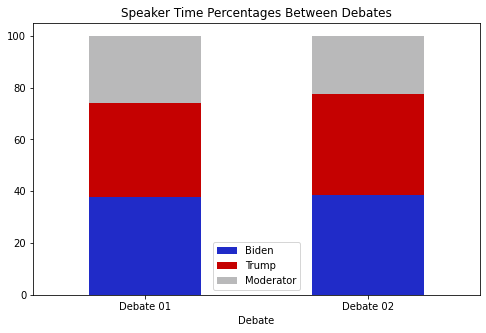

In [27]:
# plot the percentages 
speaker_times.plot(x='Debate', kind='bar', stacked=True, figsize = (8,5), rot = 0,
                   title='Speaker Time Percentages Between Debates',
                   color = ['#202BC8', '#C50101', '#B9B9BA'])
plt.show()

This once again showed that the time is split very evenly between Trump and Biden, with the moderating getting slightly less time, which makes sense. I then moved on to look at the pattern of statement lengths throughout the debates.

In [28]:
# quick method to seperate out speakers from each debate

def get_df(df, speaker):
    idx = df['speaker'] == speaker
    return df[idx].copy().reset_index(drop = True)

C:\Users\User\AppData\Local\Temp\ipykernel_308\4045322357.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\User\AppData\Local\Temp\ipykernel_308\4045322357.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


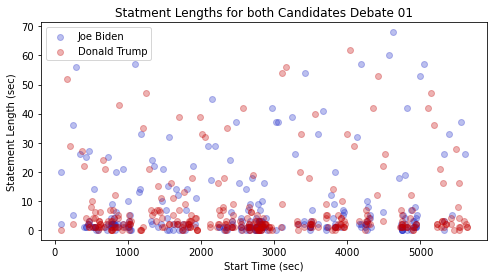

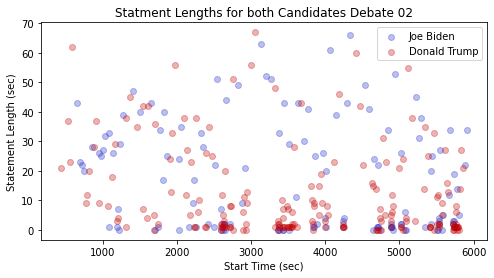

In [29]:
#debate 1
fig, ax, = plt.subplots(1, 1, figsize = (8,4))

speakers = ['Joe Biden', 'Donald Trump']
colors = ['#202BC8', '#C50101']

for i, speaker in enumerate(speakers):
    df_speaker = get_df(debate_01, speaker)
    ax.scatter(df_speaker['start_time'], df_speaker['total_time'],
               alpha = 0.3,
               color = colors[i],
               label = speaker)

ax.set_xlabel('Start Time (sec)')
ax.set_ylabel('Statement Length (sec)')
ax.set_title('Statment Lengths for both Candidates Debate 01')
ax.legend()

fig.show()

#debate02
fig, ax, = plt.subplots(1, 1, figsize = (8,4))

speakers = ['Joe Biden', 'Donald Trump']
colors = ['#202BC8', '#C50101']

for i, speaker in enumerate(speakers):
    df_speaker = get_df(debate_02, speaker)
    ax.scatter(df_speaker['start_time'], df_speaker['total_time'],
               alpha = 0.3,
               color = colors[i],
               label = speaker)

ax.set_xlabel('Start Time (sec)')
ax.set_ylabel('Statement Length (sec)')
ax.set_title('Statment Lengths for both Candidates Debate 02')
ax.legend()

fig.show()

There isn't any super clear pattern in these results. Obviously both candidates had more short statements than long ones which makes sense. This did however bring to light that there are many more observations in the first debate than the second, which is odd to me.

I then decided to quickly calculate words per minute, since competency and speaking ability has been in question for both of these candidates due to their age.

In [30]:
biden_01 = get_df(debate_01, 'Vice President Joe Biden')
biden_02 = get_df(debate_02, 'Joe Biden')
b_total_time = (biden_01['total_time'].sum() + biden_02['total_time'].sum())/60
b_total_words = biden_01['length'].sum() + biden_02['length'].sum()
b_wpm = b_total_words / b_total_time
print(b_wpm)

96.40069384215091


In [31]:
trump_01 = get_df(debate_01, 'President Donald J. Trump')
trump_02 = get_df(debate_02, 'Donald Trump')
t_total_time = (trump_01['total_time'].sum() + trump_02['total_time'].sum())/60
t_total_words = trump_01['length'].sum() + trump_02['length'].sum()
t_wpm = t_total_words / t_total_time
print(t_wpm)

104.56848432803777


Biden averaged about 8 words per minute less than trump, but both fall short of the average which is about 150. However, when we remember that I already removed stopwords, this changes our perspective and I no longer find this as concerning.

### TF-IDF

I then moved on to TFIDF for the first debate. My hope in this was to determine which topics were discussed the most.

In [32]:
pd.set_option('display.max_rows', 10)

In [33]:
debate_01 = debate_01.reset_index() 
debate_01.columns = ['doc_num', 
                            'speaker', 
                            'text', 
                            'total_time', 
                            'start_time',  
                            'tokens', 
                            'length']
debate_01

,doc_num,speaker,text,total_time,start_time,tokens,length
0,0,Chris Wallace,Good evening from the Health Education Campus ...,50,0,"[good, evening, health, education, campus, cas...",44
1,1,Chris Wallace,This debate is being conducted under health an...,39,50,"[this, conducted, health, safety, protocol, de...",44
2,2,Joe Biden,"How you doing, man?",2,89,"[how, doing, man]",3
3,3,Donald Trump,How are you doing?,0,91,"[how, doing]",2
4,4,Joe Biden,I’m well.,20,91,[well],1
...,...,...,...,...,...,...,...
783,783,Donald Trump,I want to see an honest ballot cut-,2,5629,"[want, honest, ballot, cut]",4
784,784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4,5631,"[gentleman, that, end, crosstalk, this, end]",6
785,785,Donald Trump,I want to see an honest ballot count.,1,5635,"[want, honest, ballot, count]",4
786,786,Chris Wallace,We’re going to leave it there-,1,5636,"[we, re, going, leave, there]",5


In [34]:
db01_tokens = (debate_01
                  .explode('tokens')
                  .drop(columns=['speaker',
                                'text',
                                'start_time',
                                'total_time',
                                'length'])
                )
db01_tokens.head(10)

,doc_num,tokens
0,0,good
0,0,evening
0,0,health
0,0,education
0,0,campus
0,0,case
0,0,western
0,0,reserve
0,0,university
0,0,cleveland


In [35]:
# calculating term frequency
term_frequency = (db01_tokens
                  .groupby(by=['doc_num', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )
document_frequency = (term_frequency
                      .groupby(['doc_num', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )
term_frequency = term_frequency.merge(document_frequency)
documents_in_corpus = term_frequency['doc_num'].nunique()
term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
term_frequency.sort_values(by=['term_frequency'], ascending=False)
from sklearn import preprocessing
term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')
top_n_terms = term_frequency.sort_values(by=['doc_num', 'tfidf'], ascending=[True, False]).groupby(['doc_num']).head(5)
top_n_terms.head(10)

,doc_num,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
89,0,commission,3,3.0,6.284472,18.853416,0.031391
26,0,assure,1,1.0,6.977619,6.977619,0.011618
56,0,both,1,1.0,6.977619,6.977619,0.011618
61,0,campus,1,1.0,6.977619,6.977619,0.011618
107,0,evening,1,1.0,6.977619,6.977619,0.011618
141,1,health,2,10.0,5.272871,10.545742,0.017559
548,1,no,2,37.0,4.033180,8.066360,0.013431
524,1,advisor,1,1.0,6.977619,6.977619,0.011618
528,1,boo,1,1.0,6.977619,6.977619,0.011618
529,1,cheer,1,1.0,6.977619,6.977619,0.011618


Overall I was dissapointed by these results. At first, some of the top terms were things like "debate," "presidental," and "candidate," so I went back and took them out as stop words. However, I was still left with somewhat meaningless words. It seemed like there was a lot of noise from the logistics of conducting the actual debate, so I couldn't really get at what the candidates were saying. Hence, I decided to perform TF-IDF again, this time taking out the moderator.

In [36]:
biden_trump_1 = debate_01[debate_01['speaker'] != 'Chris Wallace'] # remove lines from the moderator
biden_trump_1

,doc_num,speaker,text,total_time,start_time,tokens,length
2,2,Joe Biden,"How you doing, man?",2,89,"[how, doing, man]",3
3,3,Donald Trump,How are you doing?,0,91,"[how, doing]",2
4,4,Joe Biden,I’m well.,20,91,[well],1
6,6,Donald Trump,"Thank you very much, Chris. I will tell you ve...",52,161,"[thank, much, chris, tell, simply, we, won, el...",79
7,7,Donald Trump,And we won the election and therefore we have ...,29,213,"[and, won, election, right, choose, her, peopl...",44
...,...,...,...,...,...,...,...
780,780,Donald Trump,It’s already been established. Take a look at ...,3,5595,"[it, established, take, look, carolyn, maloney...",7
782,782,Joe Biden,He has no idea what he’s talking about. Here’s...,26,5603,"[he, idea, he, talking, about, here, deal, the...",52
783,783,Donald Trump,I want to see an honest ballot cut-,2,5629,"[want, honest, ballot, cut]",4
785,785,Donald Trump,I want to see an honest ballot count.,1,5635,"[want, honest, ballot, count]",4


In [37]:
bt_tokens = (biden_trump_1
                  .explode('tokens')
                  .drop(columns=['speaker', 'text', 'total_time', 'start_time', 'length'])
                )
bt_tokens.head(10)

,doc_num,tokens
2,2,how
2,2,doing
2,2,man
3,3,how
3,3,doing
4,4,well
6,6,thank
6,6,much
6,6,chris
6,6,tell


In [38]:
term_frequency = (bt_tokens
                  .groupby(by=['doc_num', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )
document_frequency = (term_frequency
                      .groupby(['doc_num', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )
term_frequency = term_frequency.merge(document_frequency)
documents_in_corpus = term_frequency['doc_num'].nunique()
term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
term_frequency.sort_values(by=['term_frequency'], ascending=False)
from sklearn import preprocessing
term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')
top_n_terms = term_frequency.sort_values(by=['doc_num', 'tfidf'], ascending=[True, False]).groupby(['doc_num']).head(5)
top_n_terms.head(10)

,doc_num,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
7,2,how,1,4.0,5.727388,5.727388,0.011013
0,2,doing,1,7.0,5.257384,5.257384,0.010109
11,2,man,1,11.0,4.851919,4.851919,0.009329
8,3,how,1,4.0,5.727388,5.727388,0.011013
1,3,doing,1,7.0,5.257384,5.257384,0.010109
22,4,well,1,40.0,3.623254,3.623254,0.006967
111,6,election,4,19.0,4.341093,17.364374,0.033389
621,6,she,3,4.0,5.727388,17.182163,0.033039
884,6,we,5,66.0,3.132133,15.660666,0.030113
826,6,time,3,14.0,4.628776,13.886327,0.026701


Unfortunately, I once again wasn't getting at the political topics being discussed. I decided to do one last try on a town hall instead, hoping that without the back and forth of the candidates, more meaningful terms would come to light.

In [39]:
biden_th

,speaker,text,total_time,start_time,tokens,length
0,George Stephanopoulos,"Hey, and welcome to our town hall with Joe Bid...",5,0,"[joe, biden, mr, vice, president, you]",6
1,Joe Biden,Good to be with you.,1,5,"[good, you]",2
2,George Stephanopoulos,We’re here with a group of Pennsylvania voters...,15,6,"[we, re, group, pennsylvania, voter, you, they...",27
3,Joe Biden,Okay.,0,21,[okay],1
4,George Stephanopoulos,"And we’re going to start with Nicholas Fed, an...",6,21,"[and, we, re, going, start, nicholas, fed, he,...",14
...,...,...,...,...,...,...
216,Joe Biden,"Well, it could say I’m a lousy candidate, and ...",72,5075,"[well, lousy, didn, good, job, but, hope, does...",85
217,George Stephanopoulos,One more break. We’ll be right back. And we ar...,261,5147,"[one, break, we, ll, right, back, and, wrappin...",44
218,Joe Biden,"Yeah. And by the way, before I came up here, I...",71,5408,"[yeah, and, way, came, here, took, test, ve, t...",96
219,George Stephanopoulos,But you expect to be there?,1,5479,"[but, expect, there]",3


In [40]:
biden_th = biden_th.reset_index()
biden_th.columns = ['doc_num', 
                            'speaker', 
                            'text',  
                            'total_time',
                            'start_time',
                            'tokens', 
                            'length']
biden_th

,doc_num,speaker,text,total_time,start_time,tokens,length
0,0,George Stephanopoulos,"Hey, and welcome to our town hall with Joe Bid...",5,0,"[joe, biden, mr, vice, president, you]",6
1,1,Joe Biden,Good to be with you.,1,5,"[good, you]",2
2,2,George Stephanopoulos,We’re here with a group of Pennsylvania voters...,15,6,"[we, re, group, pennsylvania, voter, you, they...",27
3,3,Joe Biden,Okay.,0,21,[okay],1
4,4,George Stephanopoulos,"And we’re going to start with Nicholas Fed, an...",6,21,"[and, we, re, going, start, nicholas, fed, he,...",14
...,...,...,...,...,...,...,...
216,216,Joe Biden,"Well, it could say I’m a lousy candidate, and ...",72,5075,"[well, lousy, didn, good, job, but, hope, does...",85
217,217,George Stephanopoulos,One more break. We’ll be right back. And we ar...,261,5147,"[one, break, we, ll, right, back, and, wrappin...",44
218,218,Joe Biden,"Yeah. And by the way, before I came up here, I...",71,5408,"[yeah, and, way, came, here, took, test, ve, t...",96
219,219,George Stephanopoulos,But you expect to be there?,1,5479,"[but, expect, there]",3


In [41]:
biden_th_tokens = (biden_th
                  .explode('tokens')
                  .drop(columns=['speaker',
                                'text',
                                'start_time',
                                'total_time',
                                'length'])
                )
biden_th_tokens.head(10)

,doc_num,tokens
0,0,joe
0,0,biden
0,0,mr
0,0,vice
0,0,president
0,0,you
1,1,good
1,1,you
2,2,we
2,2,re


In [42]:
# calculating term frequency
term_frequency = (biden_th_tokens
                  .groupby(by=['doc_num', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )
document_frequency = (term_frequency
                      .groupby(['doc_num', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )
term_frequency = term_frequency.merge(document_frequency)
documents_in_corpus = term_frequency['doc_num'].nunique()
term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
# Here are our TF-IDF values!
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']
term_frequency.sort_values(by=['term_frequency'], ascending=False)
from sklearn import preprocessing
term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')
top_n_terms = term_frequency.sort_values(by=['doc_num', 'tfidf'], ascending=[True, False]).groupby(['doc_num']).head(5)
top_n_terms.head(10)

,doc_num,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
16,0,joe,1,7.0,4.323236,4.323236,0.011010
23,0,mr,1,11.0,3.917771,3.917771,0.009978
0,0,biden,1,16.0,3.569464,3.569464,0.009091
97,0,vice,1,21.0,3.311635,3.311635,0.008434
34,0,president,1,63.0,2.243794,2.243794,0.005714
197,1,good,1,13.0,3.763620,3.763620,0.009585
119,1,you,1,79.0,2.020651,2.020651,0.005146
518,2,voting,2,2.0,5.304065,10.608130,0.027016
345,2,group,2,3.0,5.016383,10.032766,0.025551
366,2,re,4,65.0,2.213023,8.852091,0.022544


This once again wasn't very meaningful! So, I moved on to the analysis for my four questions.

---
### Question 1: Is the President staying composed? 
### Question 2: Are they being objective?
##### Sentiment Analysis

The first thing I did was use the Textblob library to get the sentiment polarity and subjectivity for each document.

In [44]:
import pandas as pd
from textblob import TextBlob

# Function to get sentiment polarity using TextBlob
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Function to get sentiment subjectivity using TextBlob
def get_sentiment_subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.subjectivity

In [45]:
def add_sentiment(debate):
    debate['sen_polar'] = debate['text'].apply(get_sentiment_polarity)
    debate['sen_subject'] = debate['text'].apply(get_sentiment_subjectivity)

In [46]:
for debate in debates:
    add_sentiment(debate)

In [47]:
debate_vp

,speaker,text,total_time,start_time,tokens,length,sen_polar,sen_subject
0,Susan Page,Good evening. From the University of Utah in S...,81,0,"[good, evening, from, university, utah, salt, ...",144,0.152893,0.507369
1,Susan Page,"These are tumultuous times, but we can and wil...",52,81,"[these, tumultuous, time, respectful, exchange...",70,0.068106,0.345076
2,Kamala Harris,"Thank you, Susan. Well, the American people ha...",68,133,"[thank, you, susan, well, american, people, wi...",70,0.048333,0.233333
3,Kamala Harris,"Can you imagine if you knew on January 28th, a...",56,201,"[can, imagine, knew, january, th, opposed, mar...",86,0.355000,0.472778
4,Susan Page,"Thank you, Senator Harris-",1,257,"[thank, you, senator, harris]",4,0.000000,0.000000
...,...,...,...,...,...,...,...,...
321,Kamala Harris,"First of all, I love hearing from our young le...",19,2998,"[first, all, love, hearing, young, leader, and...",20,0.310000,0.451667
322,Kamala Harris,"And brings me to Joe, Joe Biden. One of the re...",27,3017,"[and, brings, joe, joe, biden, one, reason, jo...",32,-0.140000,0.673333
323,Kamala Harris,Joe has a longstanding reputation of working a...,26,3044,"[joe, longstanding, reputation, working, aisle...",34,0.500000,0.600000
324,Kamala Harris,"Brecklin, when you think about the future, I d...",27,3070,"[brecklin, think, future, believe, future, bri...",26,0.175000,0.293750


In [48]:
# For some reason the first debate didn't run in the loop so I added the sentiment manually here
debate_01['sen_polar'] = debate_01['text'].apply(get_sentiment_polarity)
debate_01['sen_subject'] = debate_01['text'].apply(get_sentiment_subjectivity)

In [49]:
debate_01

,doc_num,speaker,text,total_time,start_time,tokens,length,sen_polar,sen_subject
0,0,Chris Wallace,Good evening from the Health Education Campus ...,50,0,"[good, evening, health, education, campus, cas...",44,0.237500,0.383333
1,1,Chris Wallace,This debate is being conducted under health an...,39,50,"[this, conducted, health, safety, protocol, de...",44,0.310119,0.568452
2,2,Joe Biden,"How you doing, man?",2,89,"[how, doing, man]",3,0.000000,0.000000
3,3,Donald Trump,How are you doing?,0,91,"[how, doing]",2,0.000000,0.000000
4,4,Joe Biden,I’m well.,20,91,[well],1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
783,783,Donald Trump,I want to see an honest ballot cut-,2,5629,"[want, honest, ballot, cut]",4,0.600000,0.900000
784,784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4,5631,"[gentleman, that, end, crosstalk, this, end]",6,0.000000,0.000000
785,785,Donald Trump,I want to see an honest ballot count.,1,5635,"[want, honest, ballot, count]",4,0.600000,0.900000
786,786,Chris Wallace,We’re going to leave it there-,1,5636,"[we, re, going, leave, there]",5,0.000000,0.000000


I then calculated the averatge polarity and subjectivity average for each candidate in the two debates.

In [50]:
joe_debate_1 = debate_01[debate_01['speaker'] == 'Joe Biden']
trump_debate_1 = debate_01[debate_01['speaker'] == 'Donald Trump']
print('Debate One')
print(f"""Biden Subjectivity Average: {joe_debate_1['sen_subject'].mean()}""")
print(f"""Trump Subjectivity Average: {trump_debate_1['sen_subject'].mean()}""")
print(f"""Biden Polarity Average: {joe_debate_1['sen_polar'].mean()}""")
print(f"""Trump Polarity Average: {trump_debate_1['sen_polar'].mean()}\n""")

joe_debate_2 = debate_02[debate_02['speaker'] == 'Joe Biden']
trump_debate_2 = debate_02[debate_02['speaker'] == 'Donald Trump']
print('Debate Two')
print(f"""Biden Subjectivity Average: {joe_debate_2['sen_subject'].mean()}""")
print(f"""Trump Subjectivity Average: {trump_debate_2['sen_subject'].mean()}""")
print(f"""Biden Polarity Average: {joe_debate_2['sen_polar'].mean()}""")
print(f"""Trump Polarity Average: {trump_debate_2['sen_polar'].mean()}""")

Debate One
Biden Subjectivity Average: 0.30863115928586377
Trump Subjectivity Average: 0.24642842807714607
Biden Polarity Average: 0.06761508450400348
Trump Polarity Average: 0.043132912457342236

Debate Two
Biden Subjectivity Average: 0.31490857889171386
Trump Subjectivity Average: 0.281447852740352
Biden Polarity Average: 0.051785413313371456
Trump Polarity Average: 0.01813207412106408


Things seem pretty consistent, except Trump's polarity dips in the second debate.

I then moved on to visualize these distributions.

Text(0.5, 1.0, 'Sentiment Subjectivity Between Candidates and Debates')

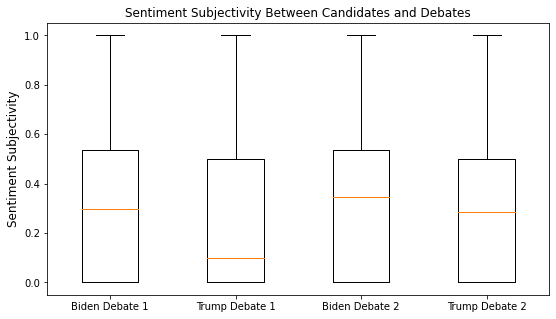

In [51]:
# visualize subjectivity with boxplots
import matplotlib.pyplot as plt
data = [joe_debate_1['sen_subject'].values, trump_debate_1['sen_subject'].values,
        joe_debate_2['sen_subject'].values, trump_debate_2['sen_subject'].values]
# Create boxplot

fig, ax = plt.subplots (1, 1, figsize = (9,5) )
ax.boxplot(x = data, labels = ['Biden Debate 1', 'Trump Debate 1', 'Biden Debate 2', 'Trump Debate 2'])
ax.set_ylabel('Sentiment Subjectivity', fontsize = 12)
ax.set_title('Sentiment Subjectivity Between Candidates and Debates')

In [52]:
fig.savefig(f'Figures/SenSubject.png', bbox_inches = 'tight')

Text(0.5, 1.0, 'Sentiment Polarity Between Candidates and Debates')

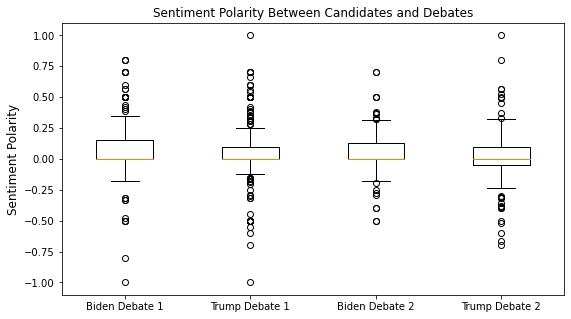

In [53]:
# visualize polarity with boxplots
import matplotlib.pyplot as plt
data = [joe_debate_1['sen_polar'].values, trump_debate_1['sen_polar'].values,
        joe_debate_2['sen_polar'].values, trump_debate_2['sen_polar'].values]
# Create boxplot

fig, ax = plt.subplots (1, 1, figsize = (9,5) )
ax.boxplot(x = data, labels = ['Biden Debate 1', 'Trump Debate 1', 'Biden Debate 2', 'Trump Debate 2'])
ax.set_ylabel('Sentiment Polarity', fontsize = 12)
ax.set_title('Sentiment Polarity Between Candidates and Debates', fontsize = 12)

In [54]:
fig.savefig(f'Figures/SenPolar.png', bbox_inches = 'tight')

---
### Question 3: Is the candidate conveying their plan for action?
##### Examining Action Verbs

To analyze this, I tagged the tokens with nltk's part of speach tagger. I then calculated the ratio of tokens that were verbs to the total.

In [55]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
def get_verbs(tokens):
    tagged_tokens = pos_tag(tokens) # tag the tokens
    return [token for token, tag in tagged_tokens if tag.startswith('VB')] # only extract the tokens that are verbs
debate_01['verbs'] = debate_01['tokens'].apply(lambda x: get_verbs(x))
debate_01['verb:token_ratio'] = debate_01.apply(lambda x: len(x.verbs)/len(x.tokens), axis=1) #calculate the ratio
debate_02['verbs'] = debate_02['tokens'].apply(lambda x: get_verbs(x))
debate_02['verb:token_ratio'] = debate_02.apply(lambda x: len(x.verbs)/len(x.tokens), axis=1)
debate_01

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,doc_num,speaker,text,total_time,start_time,tokens,length,sen_polar,sen_subject,verbs,verb:token_ratio
0,0,Chris Wallace,Good evening from the Health Education Campus ...,50,0,"[good, evening, health, education, campus, cas...",44,0.237500,0.383333,"[donald, sponsored, designed, rest, agreed, de...",0.159091
1,1,Chris Wallace,This debate is being conducted under health an...,39,50,"[this, conducted, health, safety, protocol, de...",44,0.310119,0.568452,"[conducted, designed, serving, agreed, beginni...",0.159091
2,2,Joe Biden,"How you doing, man?",2,89,"[how, doing, man]",3,0.000000,0.000000,[doing],0.333333
3,3,Donald Trump,How are you doing?,0,91,"[how, doing]",2,0.000000,0.000000,[doing],0.500000
4,4,Joe Biden,I’m well.,20,91,[well],1,0.000000,0.000000,[],0.000000
...,...,...,...,...,...,...,...,...,...,...,...
783,783,Donald Trump,I want to see an honest ballot cut-,2,5629,"[want, honest, ballot, cut]",4,0.600000,0.900000,[],0.000000
784,784,Chris Wallace,"Gentlemen, just say that’s the end of it [cros...",4,5631,"[gentleman, that, end, crosstalk, this, end]",6,0.000000,0.000000,[end],0.166667
785,785,Donald Trump,I want to see an honest ballot count.,1,5635,"[want, honest, ballot, count]",4,0.600000,0.900000,[],0.000000
786,786,Chris Wallace,We’re going to leave it there-,1,5636,"[we, re, going, leave, there]",5,0.000000,0.000000,"[re, going, leave]",0.600000


I then moved on to plot these results with a boxplot.

Text(0.5, 1.0, 'How Often do Candidates Use Verbs')

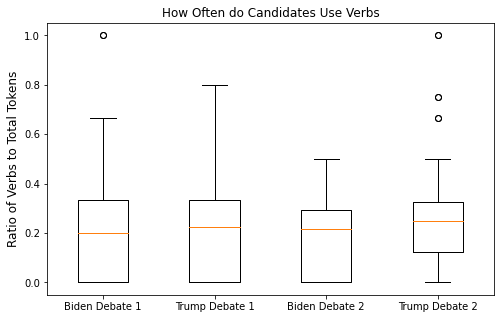

In [56]:
biden_ratio_1 = debate_01[debate_01['speaker'] == 'Joe Biden']
trump_ratio_1 = debate_01[debate_01['speaker'] == 'Donald Trump']
biden_ratio_2 = debate_02[debate_02['speaker'] == 'Joe Biden']
trump_ratio_2 = debate_02[debate_02['speaker'] == 'Donald Trump']

data = [biden_ratio_1['verb:token_ratio'].values, 
        trump_ratio_1['verb:token_ratio'].values,
        biden_ratio_2['verb:token_ratio'].values, 
        trump_ratio_2['verb:token_ratio'].values]
# Create boxplot

fig, ax = plt.subplots (1, 1, figsize = (8,5))
ax.boxplot(x = data, 
           labels = ['Biden Debate 1', 'Trump Debate 1', 'Biden Debate 2', 'Trump Debate 2'], 
          )
ax.set_ylabel('Ratio of Verbs to Total Tokens', fontsize = 12)
ax.set_title('How Often do Candidates Use Verbs', fontsize = 12)

In [57]:
fig.savefig(f'Figures/Verbs.png', bbox_inches = 'tight')

---
### Question 4: Is this performance similar to the candidate's previous ones? Are they staying consistent?
##### Doc2Vec and Clustering

As I mentioned in my write up, this model would theoretically be made up of much more of their past performances and then the current debate would be compared to them using doc similarity. However, since this is the data I had already cleaned I decided to just use this to have something to compare the 2024 debates to.

I first created copies of the databases, only keeping the names of the presidential and vp candidates and changing the rest to "moderator." I also combined all the debates into one dataframe, creating columns for the name of the debate to be used later.

In [71]:
debate_01.name = 'debate_01'
debate_02.name = 'debate_02'
debate_vp.name = 'debate_vp'
biden_th.name = 'biden_th'
trump_th.name = 'trump_th'

In [72]:
def new_name_columns(debate):
    debate_new = debate.copy(deep = True)
    #standardize speaker names for non-politicians
    debate_new['speaker'] = debate_new['speaker'].apply(lambda x: 'moderator' 
                                                        if ((x != 'Donald Trump') 
                                                            and (x != 'Joe Biden')
                                                            and (x != 'Kamala Harris')
                                                            and (x != 'Mike Pence')
                                                           )
                                                        else x )
    # add in the name of the debate the text is from
    debate_new['debate'] = debate.name
    # new column with both debate and speaker
    debate_new['speaker,debate'] = list(zip(debate_new.speaker, debate_new.debate))
    return debate_new
debate_01_label = new_name_columns(debate_01)
debate_02_label = new_name_columns(debate_02)
debate_vp_label = new_name_columns(debate_vp)
biden_th_label = new_name_columns(biden_th)
trump_th_label = new_name_columns(trump_th)

In [73]:
biden_th_label

,doc_num,speaker,text,total_time,start_time,tokens,length,debate,"speaker,debate"
0,0,moderator,"Hey, and welcome to our town hall with Joe Bid...",5,0,"[joe, biden, mr, vice, president, you]",6,biden_th,"(moderator, biden_th)"
1,1,Joe Biden,Good to be with you.,1,5,"[good, you]",2,biden_th,"(Joe Biden, biden_th)"
2,2,moderator,We’re here with a group of Pennsylvania voters...,15,6,"[we, re, group, pennsylvania, voter, you, they...",27,biden_th,"(moderator, biden_th)"
3,3,Joe Biden,Okay.,0,21,[okay],1,biden_th,"(Joe Biden, biden_th)"
4,4,moderator,"And we’re going to start with Nicholas Fed, an...",6,21,"[and, we, re, going, start, nicholas, fed, he,...",14,biden_th,"(moderator, biden_th)"
...,...,...,...,...,...,...,...,...,...
216,216,Joe Biden,"Well, it could say I’m a lousy candidate, and ...",72,5075,"[well, lousy, didn, good, job, but, hope, does...",85,biden_th,"(Joe Biden, biden_th)"
217,217,moderator,One more break. We’ll be right back. And we ar...,261,5147,"[one, break, we, ll, right, back, and, wrappin...",44,biden_th,"(moderator, biden_th)"
218,218,Joe Biden,"Yeah. And by the way, before I came up here, I...",71,5408,"[yeah, and, way, came, here, took, test, ve, t...",96,biden_th,"(Joe Biden, biden_th)"
219,219,moderator,But you expect to be there?,1,5479,"[but, expect, there]",3,biden_th,"(moderator, biden_th)"


In [74]:
# combine all debates into one dataframe
all_debates = pd.concat([debate_01_label, debate_02_label, debate_vp_label, biden_th_label, trump_th_label])
all_debates.drop(['doc_num', 'total_time', 'start_time', 'length', 
                  'sen_polar', 'sen_subject' ], axis = 1, inplace = True)
all_debates

,speaker,text,tokens,verbs,verb:token_ratio,debate,"speaker,debate"
0,moderator,Good evening from the Health Education Campus ...,"[good, evening, health, education, campus, cas...","[donald, sponsored, designed, rest, agreed, de...",0.159091,debate_01,"(moderator, debate_01)"
1,moderator,This debate is being conducted under health an...,"[this, conducted, health, safety, protocol, de...","[conducted, designed, serving, agreed, beginni...",0.159091,debate_01,"(moderator, debate_01)"
2,Joe Biden,"How you doing, man?","[how, doing, man]",[doing],0.333333,debate_01,"(Joe Biden, debate_01)"
3,Donald Trump,How are you doing?,"[how, doing]",[doing],0.500000,debate_01,"(Donald Trump, debate_01)"
4,Joe Biden,I’m well.,[well],[],0.000000,debate_01,"(Joe Biden, debate_01)"
...,...,...,...,...,...,...,...
399,Donald Trump,That’s right.,"[that, right]",NaN,NaN,trump_th,"(Donald Trump, trump_th)"
400,moderator,There are people who want to know why they sho...,"[there, people, want, know, second, chance, im...",NaN,NaN,trump_th,"(moderator, trump_th)"
401,Donald Trump,Because I’ve done a great job. We have the str...,"[because, ve, great, job, we, strongest, econo...",NaN,NaN,trump_th,"(Donald Trump, trump_th)"
402,moderator,I got to leave it there. I got a wrap from the...,"[got, leave, there, got, wrap, control, room, ...",NaN,NaN,trump_th,"(moderator, trump_th)"


I then created my doc2vec model and clustered using tSNE to see if any groups came to light.

In [75]:
def preprocessor(text: str) -> str:
    return text.lower()

In [96]:
debate_01['length'].quantile(0.90)

38.0

In [78]:
# Preprocess the text data
preprocessed_texts = [preprocessor(text) for text in all_debates['text'].fillna('')]
# tag the documents
tagged_documents = [TaggedDocument(words=text.split(), tags = all_debates.iloc[i]['speaker']) for i, text in enumerate(preprocessed_texts)]
#create the model
model = Doc2Vec(tagged_documents, vector_size=40, window=5, min_count=5, workers=4, epochs=100)
#convert the docs to vectors
document_vectors = [model.infer_vector(tagged_document.words) for tagged_document in tagged_documents]

For my model hyperparameters, I chose a vector size of 40 since that is about the 90th percentile of the document lengths. I also chose a window of 5 since that is somewhat standard and a min count of 5, which is on the lower side since my corpus is not very large. For epochs, I figured that 100 is enough for this model.

In [79]:
#convert this to an array
document_vectors_numpy = np.array(document_vectors)

In [80]:
model.save("debate_doc2vec.model")

In the future, this model can be used to find the most similar past statement to a new statement made by Trump of Biden.

In [81]:
model = Doc2Vec.load("debate_doc2vec.model")

In [82]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
document_vectors_tsne = tsne.fit_transform(document_vectors_numpy)
tsne_df = pd.DataFrame(document_vectors_tsne, columns = ['tSNE1','tSNE2'])

C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


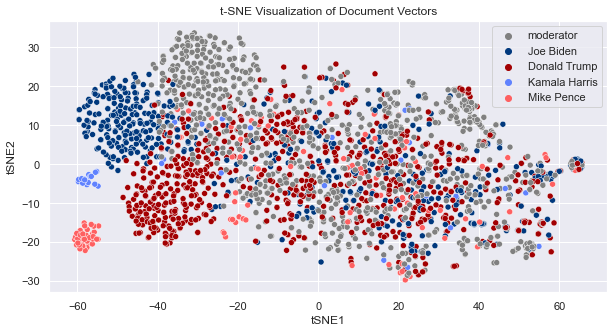

In [94]:
sns.set(rc={"figure.figsize":(10, 5)})

plot = sns.scatterplot(data = tsne_df, x = 'tSNE1', y = 'tSNE2', hue = list(all_debates['speaker']),
               palette = ['grey', '#00387D', '#A20002', '#6082FE', '#FE6061'])


plt.title('t-SNE Visualization of Document Vectors')
plt.show()

In [95]:
fig = plot.get_figure()
fig.savefig(f'Figures/Doc2vec.png', bbox_inches = 'tight')

There is a clear grouping here for both the presidential candidates as well as the vp candidates. I realized after seeing this that the model could also provide a useful tool for determining how closely the vice presidential candidates' statments track with their respective presidential candidates. I then thought that it would be interesting to see if there were clusters based debate instead of speaker.

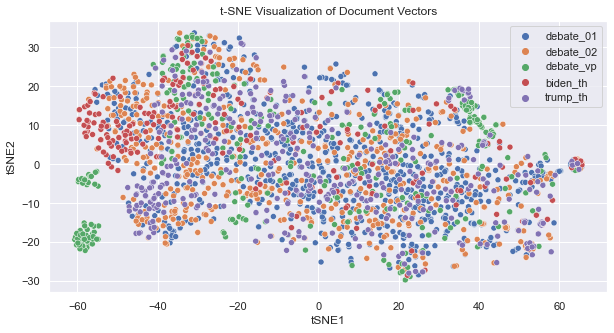

In [92]:
sns.scatterplot(data = tsne_df, x = 'tSNE1', y = 'tSNE2', hue = list(all_debates['debate']))
sns.set(rc={"figure.figsize":(10, 5)})

plt.title('t-SNE Visualization of Document Vectors')

plt.show()

Th vp debate has a couple strong groups, but besides that it seems pretty scattered. I then wanted to do a quick plot of both speaker and event to see if there was any strong grouping there.

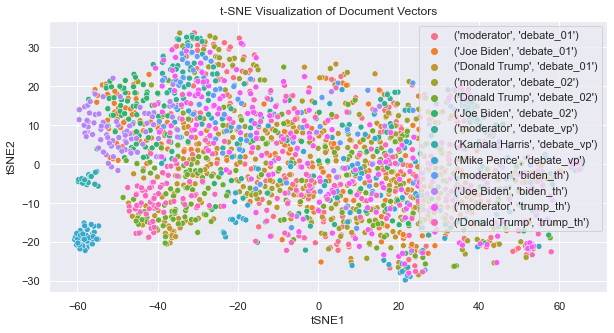

In [93]:
sns.scatterplot(data = tsne_df, x = 'tSNE1', y = 'tSNE2', hue = list(all_debates['speaker,debate']))
sns.set(rc={"figure.figsize":(10, 5)})

plt.title('t-SNE Visualization of Document Vectors')

plt.show()

Once again besides the vp debates, no clear gropus here. Hence, this is where I left off!

In the future, I think it may be interesting to differentiate between conservative and liberal moderators and see how their statements compare to each other and the candidates.